Importing cleaned data

In [1]:
import cPickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import Imputer
from sklearn import preprocessing

with open(r"20170404_HF_patients_testdata.pickle", "rb") as input_file:
    HF_patients = cPickle.load(input_file)

with open(r"20170404_testdata_scores.pickle", "rb") as input_file:
    HF_scores = cPickle.load(input_file)

HF_patients.head()

/Users/jdschonhoft/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,num_adm,hadm_id,...,Transitional Epithelial Cells,"Urine Casts, Other",Urine Color,Urobilinogen,WBC,WBC Casts,WBC Clumps,Yeast,"ACID PHOSPHATASE, PROSTATIC",Estimated Actual Glucose
0,2,3,M,2025-04-11,2102-06-14,NaT,2102-06-14,1,1,145834,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8,9,M,2108-01-26,2149-11-14,2149-11-14,2149-11-14,1,1,150750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,23,26,M,2054-05-04,2128-02-25,NaT,2128-02-25,1,1,197661,...,NaN,NaN,NaN,4.0,0.0,NaN,NaN,NaN,NaN,NaN
3,26,30,M,1872-10-14 00:00:00,NaT,NaT,NaT,0,1,104557,...,NaN,NaN,NaN,0.2,717.0,NaN,NaN,NaN,NaN,NaN
4,33,37,M,2114-09-17,2185-01-06,2185-01-06,2185-01-06,1,1,188670,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now preparing data for ML pipeline

- Removing tests that have less than 2000 patients with values
- Adding in gender as a discrete feature (e.g. 0 or 1)
- Filling NaNs with mean of respective column
- Normalizing all data between 0 and 1
- Removing patients that died in the hospital


In [2]:
#Preparing data for ML pipeline
test_names = HF_scores[HF_scores['N'] > 3000.].sort('P-value')['label']
X = HF_patients[test_names].copy()
y = HF_patients['expire_flag']


#incorporating gender
X['gender'] = [int(i) for i in HF_patients['gender'] == 'M']

# Filling NaN's with mean
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
X_imp = imp.fit_transform(X)
X_imp = pd.DataFrame(data = X_imp, columns = X.keys())
X_imp.head()

# Normalizing data

min_max_scaler = preprocessing.RobustScaler()
X_norm = min_max_scaler.fit_transform(X_imp.dropna())
X_norm = pd.DataFrame(data = X_norm, columns = X.keys())

print X.shape

#removing people who died in the hospital
patient_list = HF_patients[HF_patients['mortality_time'] > 1.].index.values.tolist()
patient_list = HF_patients.index.values.tolist()
X_subset = X_norm.iloc[patient_list].copy()
y = [y[i] for i in patient_list]

print X_subset.shape
print 'The number of dead versus alive: ', float(sum(y))/float(len(y))

/Users/jdschonhoft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


(6953, 56)
(6953, 56)
The number of dead versus alive:  0.561196605782


Fitting a simple decision tree to find the most important features and test the ability of an ML algorithm to predict 

In [14]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
_
from sklearn.cross_validation import ShuffleSplit
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# model = svm.SVC(kernel='linear', C = 1.0)
# model = GaussianNB()

# splitting data
X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.3, random_state=42)
X_train.head()

classifier = RandomForestClassifier(max_features = 10)

params = {'max_depth' : range(1,3), 'n_estimators' : [1, 2, 5, 10, 50]} #'max_features' : range(1,10)

cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.2, random_state=0)

scoring_fnc = make_scorer(accuracy_score)

grid = GridSearchCV(classifier, params, scoring=scoring_fnc, cv=cv)

grid = grid.fit(X_train, y_train)

# model = GridSearchCV(estimator=estimator, cv=cv, param_grid=params, scoring=accuracy_score)
# model.fit(X_train, y_train)


Printing the optimal parameters

In [15]:
print grid.best_estimator_.get_params()['max_features']
print grid.best_estimator_.get_params()['n_estimators']

10
50


Now testing prediction as a fucntion of DT depth

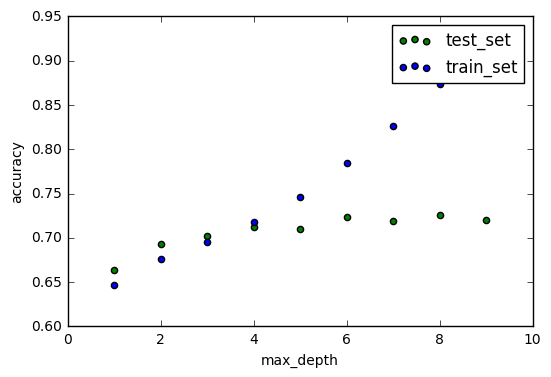

In [17]:
accuracy_test = []
accuracy_train = []
max_depth = []
for i in range(1,10):
    classifier = RandomForestClassifier(max_depth = i, max_features = 50, n_estimators = 50)
    classifier.fit(X_train, y_train)
    pred_train = classifier.predict(X_train)
    pred_test = classifier.predict(X_test)
    accuracy_train.append(accuracy_score(pred_train, y_train))
    accuracy_test.append(accuracy_score(pred_test, y_test))
    max_depth.append(i)
plt.figure()
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.scatter(max_depth, accuracy_test, label = 'test_set', c = 'green')
plt.scatter(max_depth, accuracy_train, label = 'train_set', c = 'blue')
plt.legend()
plt.show()

In [23]:
model = RandomForestClassifier(max_depth = 3, max_features = 9, n_estimators = 50)
model.fit(X_train, y_train)
predicted = model.predict(X_test)

print 'accuracy = ', accuracy_score(predicted, y_test)
print 'recall = ' , recall_score(predicted, y_test)
print 'F1-score = ', f1_score(predicted, y_test)
print 'precision = ', precision_score(predicted, y_test)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
labels_dict = dict(zip(range(len(X_train.keys())), X_train.keys()))
labels_order = [labels_dict[i] for i in indices]

std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
freq_series = pd.Series.from_array(importances[indices])


# now to plot the figure...
plt.figure(figsize=(12, 4))
ax = freq_series.plot(kind='bar')
ax.set_title("Lab Importances By Decision Tree")
ax.set_xlabel("Lab Test")
ax.set_ylabel("DT Importances")
ax.set_xticklabels(labels_order)


plt.show()

ValueError: max_features must be in (0, n_features]

In [155]:
import seaborn as sns

X_topten = X_subset[labels_order[0:10]].copy()
X_topten = X_topten.dropna() 
X_topten['mortality'] = y

# sns.pairplot(X_topten, hue = 'mortality',diag_kind="kde")
# plt.show()

Now trying SVM

In [206]:
X_train, X_test, y_train, y_test = train_test_split(X_subset[labels_order[0:2]].copy(), y, test_size=0.33, random_state=42)

classifier = svm.SVC()

params = {'C' : [1.0, 10., 100.], 'kernel' : ['linear', 'rbf'] }

cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.2, random_state=0)

scoring_fnc = make_scorer(accuracy_score)

grid = GridSearchCV(classifier, params, scoring=scoring_fnc, cv=cv)

grid = grid.fit(X_train, y_train)

print grid.best_estimator_.get_params()['C']
print grid.best_estimator_.get_params()['kernel']

100.0
rbf


In [21]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X_subset[labels_order[0:2]].copy(), y, test_size=0.33, random_state=42)
X_train.head()

model = svm.SVC() # kernel='rbf', C = 100.0
model.fit(X_train, y_train)
pred_test = model.predict(X_test)
pred_train = model.predict(X_train)

print 'accuracy if I predict all alive = ', accuracy_score([1]*len(y_test), y_test)
print 'accuracy _training set = ', accuracy_score(pred_train, y_train)
print 'accuracy = ', accuracy_score(pred_test, y_test)
print 'recall = ' , recall_score(pred_test, y_test)
print 'F1-score = ', f1_score(pred_test, y_test)
print 'precision = ', precision_score(pred_test, y_test)


accuracy if I predict all alive =  0.562527233115
accuracy _training set =  0.675182481752
accuracy =  0.688453159041
recall =  0.703389830508
F1-score =  0.735869966753
precision =  0.771494965143


Naive Bayes

In [254]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
pred_test = gnb.fit(X_train, y_train).predict(X_test)

print 'accuracy = ', accuracy_score(pred_test, y_test)
print 'recall = ' , recall_score(pred_test, y_test)
print 'F1-score = ', f1_score(pred_test, y_test)
print 'precision = ', precision_score(pred_test, y_test)

accuracy =  0.661873638344
recall =  0.754195459033
F1-score =  0.663194444444
precision =  0.591789310612


Adaboost

In [256]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=200)

bdt.fit(X_train, y_train)
pred_test = bdt.predict(X_test)

print 'accuracy = ', accuracy_score(pred_test, y_test)
print 'recall = ' , recall_score(pred_test, y_test)
print 'F1-score = ', f1_score(pred_test, y_test)
print 'precision = ', precision_score(pred_test, y_test)



accuracy =  0.684967320261
recall =  0.688328912467
F1-score =  0.741693461951
precision =  0.80402788536


Neural Network

In [5]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(X_train, y_train)

pred_test = clf.predict(X_test)

print 'accuracy = ', accuracy_score(pred_test, y_test)
print 'recall = ' , recall_score(pred_test, y_test)
print 'F1-score = ', f1_score(pred_test, y_test)
print 'precision = ', precision_score(pred_test, y_test)



accuracy =  0.695589645254
recall =  0.745487364621
F1-score =  0.722343681679
precision =  0.700593723494


In [259]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train) 
pred_test = neigh.predict(X_test)

print 'accuracy = ', accuracy_score(pred_test, y_test)
print 'recall = ' , recall_score(pred_test, y_test)
print 'F1-score = ', f1_score(pred_test, y_test)
print 'precision = ', precision_score(pred_test, y_test)



accuracy =  0.631808278867
recall =  0.666666666667
F1-score =  0.678585013313
precision =  0.69093725794


ICD9 codes for my reference

'Heart Failure' = 4280

'Atrial fibrillation' = 42731

'Hypertension NOS (Unspecified essential hypertension)' = 4019

'Coronary atherosclerosis of native coronary artery' = 41401

'Acute kidney failure' = 5849

'Diabetes mellitus' = 25000

'Acute respiratory failure' = 51881

'Hyperlipidemia' = 2724

'Urine Tract Infection' = 5990

'Subendo Infarct, Initial (Subendocardial Infarction, Initial Episode Of Care)' = 41071

'Chronic airway obstruction, not elsewhere classified' = 496

'Pneumonia, organism unspecified' = 486

'Aortic Valve Disorder (Aortic Valve Disorders)' = 4240

'Anemia NOS (Anemia, Unspecified)' = 2859

Now clustering using dimensionality reduction. 

/Users/jdschonhoft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


[ 0.30004404  0.45976864]


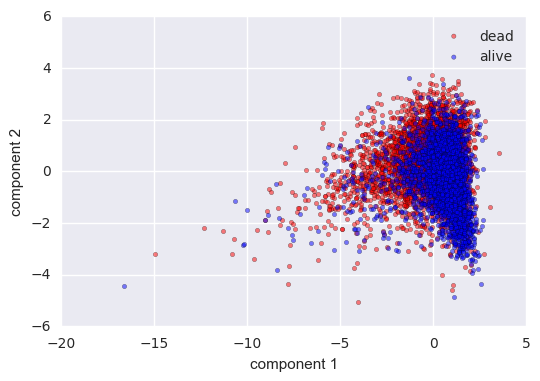

In [212]:
# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
from sklearn.decomposition import PCA

X_topten = X_subset[labels_order[0:10]].copy()
X_topten = X_topten.dropna() 
X_topten['mortality'] = y


pca = PCA(n_components=2)
data = X_topten.copy().convert_objects(convert_numeric=True)
data.replace([np.inf, -np.inf], np.nan)
data.dropna()
data = np.array(data)
data =  data[:,1:10]
data[data == -np.inf] = float(0.0000000001)

pca.fit(data)

# TODO: Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(data)

print np.cumsum(pca.explained_variance_ratio_)


from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(pca_samples)
kmeans.labels_
centers = kmeans.cluster_centers_

df_pca = pd.DataFrame(pca_samples, columns = ['c1', 'c2'])
df_pca['mortality'] = X_topten['mortality']
plt.figure()
x_dead = df_pca[df_pca['mortality'] == 1]['c1']
y_dead = df_pca[df_pca['mortality'] == 1]['c2']
x_alive = df_pca[df_pca['mortality'] == 0]['c1']
y_alive = df_pca[df_pca['mortality'] == 0]['c2']

plt.scatter(x_dead, y_dead, c ='red' , s = 10, alpha = 0.5, label = 'dead')
plt.scatter(x_alive, y_alive, c ='blue' , s = 10, alpha = 0.5, label = 'alive')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.legend()
plt.show()

In [213]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
d = model.fit_transform(data) 

df_tsne = pd.DataFrame(d, columns = ['tsne-x', 'tsne-y'])
df_tsne['mortality'] = X_topten['mortality']

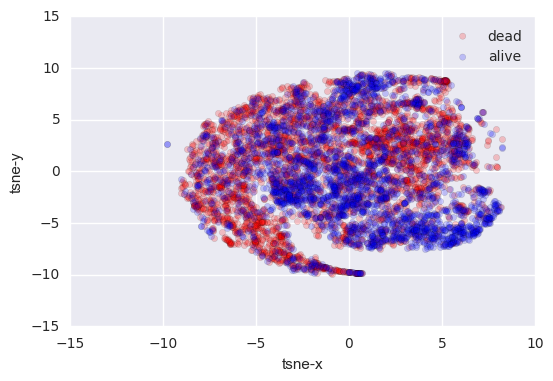

In [230]:
plt.figure()
x_dead = df_tsne[df_tsne['mortality'] == 1]['tsne-x']
y_dead = df_tsne[df_tsne['mortality'] == 1]['tsne-y']
x_alive = df_tsne[df_tsne['mortality'] == 0]['tsne-x']
y_alive = df_tsne[df_tsne['mortality'] == 0]['tsne-y']

plt.scatter(x_dead, y_dead, c ='red' , s = 20, alpha = 0.2, label = 'dead')
plt.scatter(x_alive, y_alive, c ='blue' , s = 20, alpha = 0.2, label = 'alive')
plt.xlabel('tsne-x')
plt.ylabel('tsne-y')
plt.legend()
plt.show()

Next pulling out comorbidities or codiagnoses in different clusters

In [220]:
import psycopg2
%matplotlib inline

# Connect to local copy of the MIMIC III database
sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'mimiciii'

# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

#Next creating dataframe of patient information with id 
patient_list = ', '.join([str(i) for i in HF_patients['subject_id']])
query = 'SELECT * FROM diagnoses_icd WHERE subject_id IN (%s)' % patient_list

# creating pandas data frame with patient demographics. Note that dates are shifted to that patients cannot be identified.
ICD = pd.read_sql_query(query, con)

#adding diagnostic codes to main dataframe
HF_patients['icd9_code'] = [ICD[ICD['subject_id'] == 115]['icd9_code'].tolist() for i in HF_patients['subject_id']]

#counting most common diagnoses
print ICD['icd9_code'].value_counts()[0:12]

4280     6523
42731    3082
4019     2780
41401    2600
5849     1872
25000    1610
51881    1486
2724     1377
5990     1122
41071     991
496       944
486       915
Name: icd9_code, dtype: int64


In [221]:
#making ICD9 doagnostic lookup table
query = 'SELECT * FROM d_icd_diagnoses'
lookuptable = pd.read_sql_query(query, con)
lookuptable.head()

,row_id,icd9_code,short_title,long_title
0,174,01166,TB pneumonia-oth test,"Tuberculous pneumonia [any form], tubercle bac..."
1,175,01170,TB pneumothorax-unspec,"Tuberculous pneumothorax, unspecified"
2,176,01171,TB pneumothorax-no exam,"Tuberculous pneumothorax, bacteriological or h..."
3,177,01172,TB pneumothorx-exam unkn,"Tuberculous pneumothorax, bacteriological or h..."
4,178,01173,TB pneumothorax-micro dx,"Tuberculous pneumothorax, tubercle bacilli fou..."


In [222]:
df_tsne.head()

,tsne-x,tsne-y,mortality
0,2.421645,2.419123,1
1,2.377611,8.632893,1
2,0.317204,-2.778711,1
3,-4.476172,-4.338705,0
4,0.923328,5.800712,1


Now plotting top comorbidities for the entire dataset

/Users/jdschonhoft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


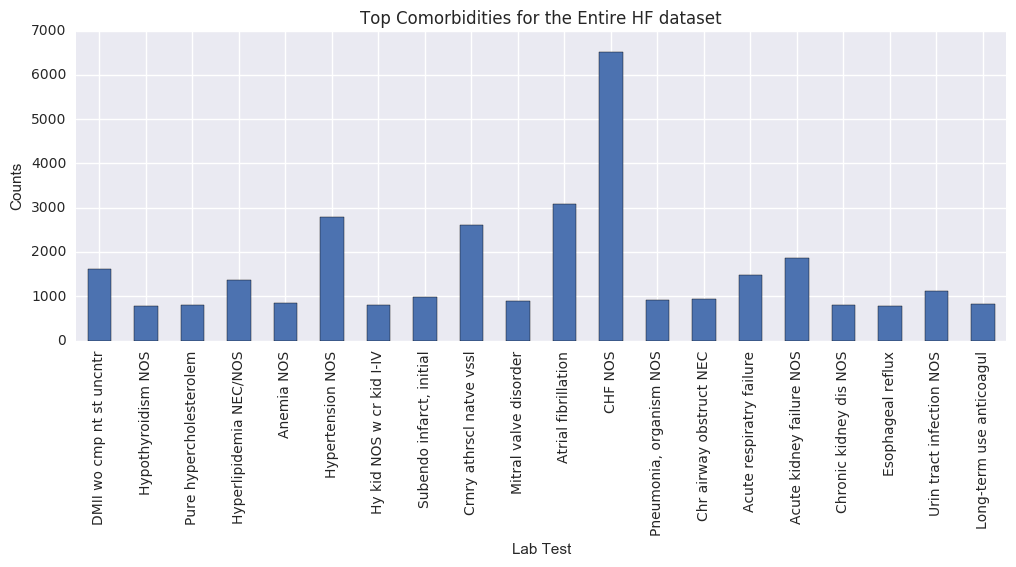

In [245]:
top = ICD['icd9_code'].value_counts()
subset = lookuptable[lookuptable['icd9_code'].isin(top.keys()[0:20])]
subset['counts'] = [top[i] for i in subset['icd9_code']]

# now to plot the figure...
plt.figure(figsize=(12, 4))
ax = subset['counts'].plot(kind='bar')
ax.set_title("Top Comorbidities for the Entire HF dataset")
ax.set_xlabel("Lab Test")
ax.set_ylabel("Counts")
ax.set_xticklabels(subset['short_title'])


plt.show()

In [232]:
# from sklearn.neighbors import DistanceMetric
# dist = DistanceMetric.get_metric('euclidean')
# tsne = np.vstack([[-2.5,-7.5], df.iloc[:, 0:2].as_matrix()])

# df['dist'] = dist.pairwise(tsne)[0][1:]
df_tsne['subject_id'] = HF_patients['subject_id']
cluster1 = df_tsne[df_tsne['tsne-x'] < -5.0]
cluster1.head()

,tsne-x,tsne-y,mortality,subject_id
15,-5.240967,3.919887,1,149
17,-6.752879,-2.600519,1,163
29,-5.472533,-2.937842,1,245
53,-7.894087,-3.065818,1,413
54,-8.559183,1.008649,1,414


/Users/jdschonhoft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


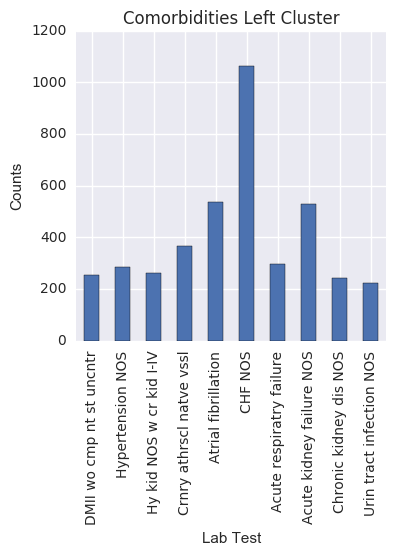

In [252]:
#left cluster, simple less than 5 in x coordinate
cluster1 = df_tsne[df_tsne['tsne-x'] < -5.0]
cluster1.head()

test_cluster = ICD[ICD['subject_id'].isin(list(cluster1['subject_id']))]
top = test_cluster['icd9_code'].value_counts()
subset = lookuptable[lookuptable['icd9_code'].isin(top.keys()[0:10])]
subset['counts'] = [top[i] for i in subset['icd9_code']]

# now to plot the figure...
plt.figure(figsize=(4, 4))
ax = subset['counts'].plot(kind='bar')
ax.set_title("Comorbidities Left Cluster")
ax.set_xlabel("Lab Test")
ax.set_ylabel("Counts")
ax.set_xticklabels(subset['short_title'])


plt.show()

/Users/jdschonhoft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


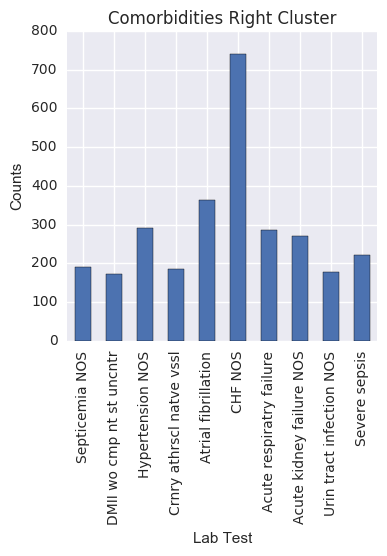

In [253]:

#defining cluster two by a box.
cluster2 = df_tsne[(df_tsne['tsne-x'] > 0) & (df_tsne['tsne-y'] > 0) & (df_tsne['tsne-x'] < 5) & (df_tsne['tsne-y'] < 5) ]
cluster2.head()

test_cluster = ICD[ICD['subject_id'].isin(list(cluster2['subject_id']))]
top = test_cluster['icd9_code'].value_counts()
subset = lookuptable[lookuptable['icd9_code'].isin(top.keys()[0:10])]
subset['counts'] = [top[i] for i in subset['icd9_code']]

# now to plot the figure...
plt.figure(figsize=(4, 4))
ax = subset['counts'].plot(kind='bar')
ax.set_title("Comorbidities Right Cluster")
ax.set_xlabel("Lab Test")
ax.set_ylabel("Counts")
ax.set_xticklabels(subset['short_title'])


plt.show()